In [9]:
dev = False
if dev:
    # Filenames (correct folder)
    inputfile = 'database/15min_houses_pv_042014_052015_v0001.csv'
    outputfile = 'test.pickle'

    # Simulation period
    start= '2014-05-01 00:00:00'  # '2014-06-9 00:00:00'
    end= '2014-05-10 23:45:00'  # '2014-06-21 23:45:00'
    f_horizon = 2  # days
    training_period = 14  # days
    f_method = 'HoltWinters'
    f_kwargs = {}
    c_method = 'opti'

    # Battery size
    nb_houses = 17
    pv_capacity = 3 * nb_houses  # kW
    battery_kWh = 6 * nb_houses   # kWh
    battery_kW = 2 * nb_houses  # kW

# Post-process inputs

In [10]:
from datetime import datetime, timedelta
import pandas
import json
from pylec import validate, optimization, forecast, metric

def display_n(df,n): 
    with pandas.option_context('display.max_rows',n*2):
        display(df)

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
        
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Convert to datetime
start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
training_period = timedelta(days=training_period)
f_horizon = timedelta(days=f_horizon) - timedelta(minutes=15)
one_day = timedelta(hours=23, minutes=45)

# Convert string to dict if necessary
if not isinstance(f_kwargs, dict):
    f_kwargs = json.loads(f_kwargs)
        
# Select the right forecast
if 'MA' == f_method:
    forecast_func = forecast.ma
elif 'SNaive' == f_method:
    forecast_func = forecast.snaive
elif 'HoltWinters' == f_method:
    forecast_func = forecast.holtwinters 
elif 'Prophet' in f_method:
    forecast_func = forecast.prophet
elif 'sklearn' in f_method:
    forecast_func = forecast.sklearn_models
elif 'keras' in f_method:
    forecast_func = forecast.keras_models  
elif f_method == 'perfect':
    forecast_func = None
else:
    raise NotImplementedError
    
# Select the right control method
if c_method == 'opti':
    control_func = optimization.pool
else:
    raise NotImplementedError
print(forecast_func)
print(control_func)

<function holtwinters at 0x7f481ab65ae8>
<function pool at 0x7f47c9c2d950>


# Loading original data (vo_houses_kW, vo_pv_coef)

In [12]:
if 'csv' in inputfile:
    df = pandas.read_csv(inputfile, parse_dates=[0], index_col=[0])
elif 'pickle' in inputfile:
    df = pandas.read_pickle(inputfile)
else:
    raise NotImplementedError
df = df.loc[:, ['vo_houses_kW', 'vo_pv_coef']]

# Assert timing
assert start in df.index
assert end in df.index
assert int(pandas.infer_freq(df.index)[:-1]) == 15

# Assert overall consumption (20000kWh is a lot)
assert df['vo_houses_kW'].sum() * 15/60 / nb_houses < 20000, f'Total conso {df["vo_houses_kW"].sum()}'

# Assert PV
assert df['vo_pv_coef'].min() >= 0
assert df['vo_pv_coef'].max() <= 1.01, f'Max PV coef = {df["vo_pv_coef"].max()}'
display_n(df, 2)

,vo_houses_kW,vo_pv_coef
Time,,
2014-04-01 00:00:00,0.000000,0.0
2014-04-01 00:15:00,6.384276,0.0
...,...,...
2015-04-30 23:30:00,5.110364,0.0
2015-04-30 23:45:00,5.703751,0.0


# Start online process

In [13]:
def logger():
    l = 'day=' + str(day.strftime('%a-%m-%d')) + '| '
    l += 't_start=' + str(training.iloc[0].name.strftime('%m-%d')) + '| '
    #l += 't_end=' + str(training.iloc[-1].name.strftime('%m-%d')) + ' | '
    l += 't_len=' + str(len(training)) + '| '
    l += 'f_len=' + str(len(dfalgo)) + '| '
    l += 'r_end=' + str(result.iloc[-1].name) + '| '
    l += 'Energy='
    l += str(emin) + ' < E < '
    l += str(emax) + ' < '
    l += str(battery_kWh) + 'kWh'
    print(l)

Note : There is no need to remove 15 minutes to dataframe training because result never includes 'day'

In [14]:
# Result frame (add training data or "real data")
start_timer = datetime.now()
result = df.loc[start-training_period:start-timedelta(minutes=15)].copy()
result['r_houses_kW'] = result['vo_houses_kW']
result['r_pv_kW'] = result['vo_pv_coef'] * pv_capacity
result['r_battery_kW'] = [0] * len(result)

# Main loop optimize once a day
days = (df.loc[start:end].groupby(pandas.Grouper(freq='D')).sum().index)
SOC_end = [battery_kWh / 2]
for day in days:
    # Retrieve historical data, and prepare future results
    training = result.loc[day-training_period:day].copy()
    dfalgo = df.loc[day:day+f_horizon].copy()
    
    # DFALGO
    # Forecasts (PV and consumption)
    dfalgo['f_pv_kW'] = dfalgo['vo_pv_coef'] * pv_capacity
    if f_method == 'perfect':
        dfalgo['f_houses_kW'] = dfalgo['vo_houses_kW']
    else:
        dfalgo['f_houses_kW'] = forecast_func(
            training['r_houses_kW'], f_horizon, **f_kwargs)

    # Control signal
    dfalgo['f_battery_kW'], SOC = control_func(
        dfalgo['f_houses_kW'], dfalgo['f_pv_kW'],
        extra={'battery_kWh': battery_kWh,
               'battery_kW':  battery_kW,
               'initial_kwh': SOC_end, 'eta': 0.95})
    emin, emax = validate.battery(
        dfalgo, (0, battery_kWh), (-battery_kW, battery_kW), SOC_end[0])
    SOC_end = SOC['SOC_end']
    
    # DFDAY
    # Select results for only one day
    dfday = df.loc[day:day+one_day].copy()
    dfday['f_houses_kW'] = dfalgo.loc[day:day+one_day, 'f_houses_kW'].copy()
    dfday['f_pv_kW'] = dfalgo.loc[day:day+one_day, 'f_pv_kW'].copy()
    dfday['f_battery_kW'] = dfalgo.loc[day:day+one_day, 'f_battery_kW'].copy()
    
    # Insert some impact of the coordination in the overall metered consump.
    dfday['r_battery_kW'] = dfday['f_battery_kW']  # Perfect forecast
    dfday['r_houses_kW'] = dfday['vo_houses_kW']  # Real = historic values
    dfday['r_pv_kW'] = dfday['f_pv_kW']  # Perfect forecast
    
    # Save for the next iteration
    result = pandas.concat([result, dfday], axis=0, sort=True)
    logger()

# Remove training from the results ?
result = result.loc[
    start:end, ['vo_houses_kW', 'vo_pv_coef',
                'f_houses_kW', 'f_pv_kW', 'f_battery_kW',
                'r_houses_kW', 'r_pv_kW', 'r_battery_kW']]
print('')
print('Result frame :')
display_n(result, 3)
time_elapsed = datetime.now() - start_timer
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

day=Thu-05-01| t_start=04-17| t_len=1344| f_len=192| r_end=2014-05-01 23:45:00| Energy=-0.0 < E < 87.72 < 102kWh
day=Fri-05-02| t_start=04-18| t_len=1344| f_len=192| r_end=2014-05-02 23:45:00| Energy=0.0 < E < 102.0 < 102kWh
day=Sat-05-03| t_start=04-19| t_len=1344| f_len=192| r_end=2014-05-03 23:45:00| Energy=-0.0 < E < 102.0 < 102kWh
day=Sun-05-04| t_start=04-20| t_len=1344| f_len=192| r_end=2014-05-04 23:45:00| Energy=0.0 < E < 102.0 < 102kWh
day=Mon-05-05| t_start=04-21| t_len=1344| f_len=192| r_end=2014-05-05 23:45:00| Energy=9.32 < E < 102.0 < 102kWh
day=Tue-05-06| t_start=04-22| t_len=1344| f_len=192| r_end=2014-05-06 23:45:00| Energy=5.81 < E < 102.0 < 102kWh
day=Wed-05-07| t_start=04-23| t_len=1344| f_len=192| r_end=2014-05-07 23:45:00| Energy=20.68 < E < 102.0 < 102kWh
day=Thu-05-08| t_start=04-24| t_len=1344| f_len=192| r_end=2014-05-08 23:45:00| Energy=-0.0 < E < 91.65 < 102kWh
day=Fri-05-09| t_start=04-25| t_len=1344| f_len=192| r_end=2014-05-09 23:45:00| Energy=0.0 < E < 

,vo_houses_kW,vo_pv_coef,f_houses_kW,f_pv_kW,f_battery_kW,r_houses_kW,r_pv_kW,r_battery_kW
Time,,,,,,,,
2014-05-01 00:00:00,4.401467,0.0,3.708704,0.0,-3.708704,4.401467,0.0,-3.708704
2014-05-01 00:15:00,5.038116,0.0,4.156412,0.0,-4.156412,5.038116,0.0,-4.156412
2014-05-01 00:30:00,4.415991,0.0,4.481268,0.0,-4.481268,4.415991,0.0,-4.481268
...,...,...,...,...,...,...,...,...
2014-05-10 23:15:00,5.442178,0.0,5.074916,0.0,-5.074916,5.442178,0.0,-5.074916
2014-05-10 23:30:00,5.946738,0.0,5.018390,0.0,-5.018390,5.946738,0.0,-5.018390
2014-05-10 23:45:00,5.807893,0.0,4.725902,0.0,-4.725902,5.807893,0.0,-4.725902


Time elapsed (hh:mm:ss.ms) 0:00:06.537792


# Calculate metrics

In [15]:
df_metric = pandas.DataFrame()

# Quality
df_metric.loc[f_method, 'MAPE_%'] = metric.mape(result, 'vo_houses_kW', 'f_houses_kW', rm_na=True)
df_metric.loc[f_method, 'MAE_kW'] = metric.mae(result, 'vo_houses_kW', 'f_houses_kW')
df_metric.loc[f_method, 'MASE'] = metric.mase(result, 'vo_houses_kW', 'f_houses_kW')
df_metric.loc[f_method, 'ME_kW'] = metric.me(result, 'vo_houses_kW', 'f_houses_kW')

# Value
r = metric.localconsumption(result, 'r_houses_kW', 'r_battery_kW', 'r_pv_kW', 15)
df_metric.loc[f_method, 'scons_%'] = r['self_consumption_%']
df_metric.loc[f_method, 'ssuff_%'] = r['self_sufficiency_%']
display(df_metric)

,MAPE_%,MAE_kW,MASE,ME_kW,scons_%,ssuff_%
HoltWinters,22.65,2.02,1.170059,0.24,76.26,80.85


f_method = HoltWinters | pv_capacity = 51kW | battery_kWh = 102kWh | Building# = 17


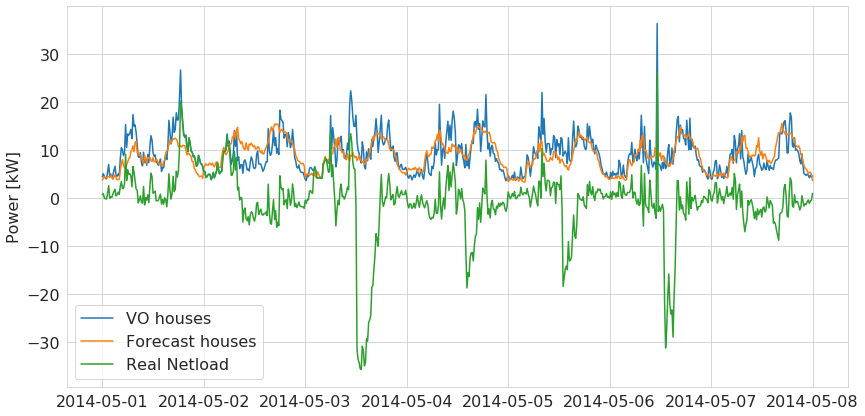

In [16]:
# Imports useful for graphics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
plt.rcParams.update({'font.size': 16})

print('f_method = ' + f_method + ' | pv_capacity = ' + str(pv_capacity)
      + 'kW | battery_kWh = ' + str(battery_kWh) + 'kWh | Building# = ' +
     str(nb_houses))
plt_end = start + timedelta(days=7)
fig = plt.figure(figsize=(14, 7))
_ = plt.plot(result.loc[start:plt_end, 'vo_houses_kW'], label='VO houses')
_ = plt.plot(result.loc[start:plt_end, 'f_houses_kW'], label='Forecast houses')
_ = plt.plot(result.loc[start:plt_end, 'r_houses_kW']
             - result.loc[start:plt_end, 'r_pv_kW']
             + result.loc[start:plt_end, 'r_battery_kW'], label='Real Netload')
_ = plt.ylabel('Power [kW]')
_ = plt.legend()

In [17]:
# Save data
if not dev:
    import pickle
    with open(outputfile, 'wb') as fp:
        pickle.dump(result, fp)